# 時系列データの特徴量の算出

## データの読み込みと可視化

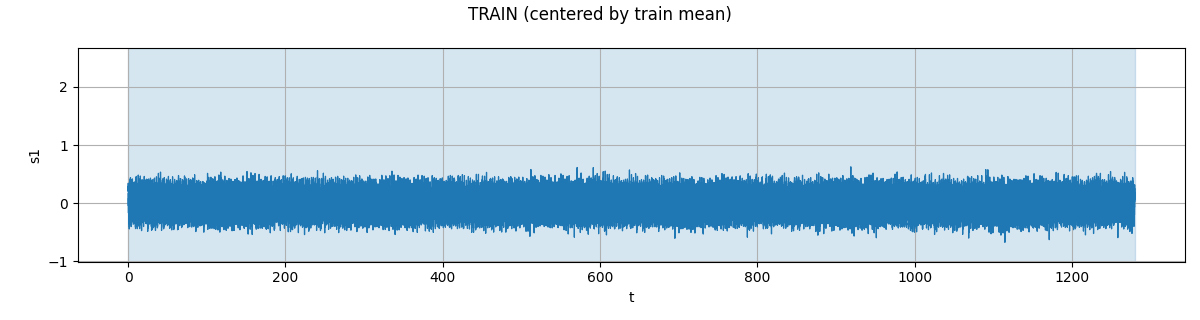

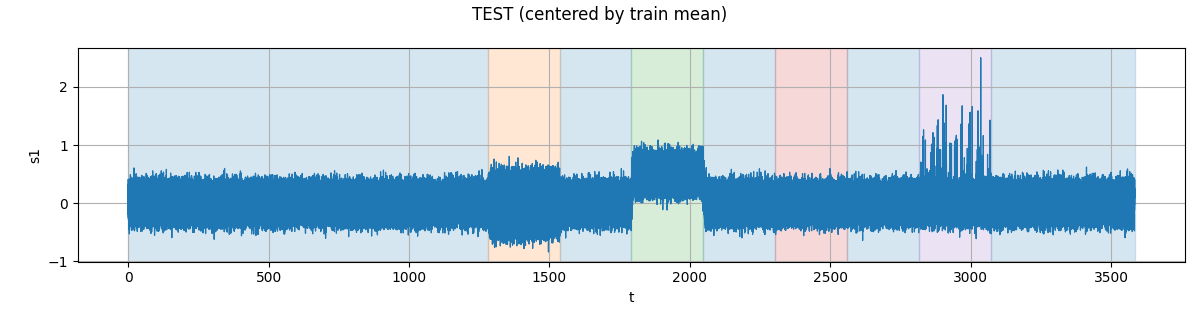

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# 設定（ここだけ）
# ============================================================
TRAIN_CSV = r"data_train_Smooth.csv"
TEST_CSV  = r"data_test_Smooth.csv"

# 指定しなければ（Noneなら）：
# TIME_COL  -> 行番号を時刻扱い
# LABEL_COL -> ラベル無し（背景塗り無し）
TIME_COL  = "t"      # 例: "t"
LABEL_COL = "label"  # 例: "label"

VALUE_COLS = ["s1"]  # 必ず指定


# ============================================================
# CSV読み込み（落ちにくく）
# ============================================================
def read_csv_robust(path: str) -> pd.DataFrame:
    last_err = None
    for enc in ("utf-8-sig", "utf-8", "cp932", "shift_jis"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    try:
        return pd.read_csv(path, encoding_errors="replace")
    except Exception as e:
        raise RuntimeError(f"CSVが読み込めませんでした: {path}\n最後のエラー: {last_err}\n最終試行エラー: {e}")


# ============================================================
# センタ（学習平均との差し引きを学習・テストに適用）
# ============================================================
def center_by_train_mean(df_tr: pd.DataFrame, df_te: pd.DataFrame, cols: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    base = df_tr[cols].mean(axis=0, skipna=True)
    tr_c = df_tr.copy()
    te_c = df_te.copy()
    tr_c[cols] = tr_c[cols] - base
    te_c[cols] = te_c[cols] - base
    return tr_c, te_c


# ============================================================
# ラベル区間（ラベルが変わるたびに区間分割）
# ============================================================
def label_segments(x: np.ndarray, labels: np.ndarray):
    if labels.size == 0:
        return []

    lab = labels.astype(object)
    for i in range(lab.size):
        if pd.isna(lab[i]):
            lab[i] = "NaN"

    segs = []
    start_i = 0
    for i in range(1, lab.size):
        if lab[i] != lab[i - 1]:
            segs.append((x[start_i], x[i - 1], lab[i - 1]))
            start_i = i
    segs.append((x[start_i], x[-1], lab[-1]))
    return segs


# ============================================================
# 学習・テストで共通のylim（列ごと）
# ============================================================
def compute_ylims(df_a: pd.DataFrame, df_b: pd.DataFrame, cols: list[str]) -> dict[str, tuple[float, float]]:
    ylims = {}
    for c in cols:
        ya = pd.to_numeric(df_a[c], errors="coerce").to_numpy(dtype=float)
        yb = pd.to_numeric(df_b[c], errors="coerce").to_numpy(dtype=float)
        y = np.concatenate([ya, yb])
        y = y[np.isfinite(y)]
        if y.size == 0:
            ylims[c] = (-1.0, 1.0)
            continue
        lo, hi = float(np.min(y)), float(np.max(y))
        if lo == hi:
            lo -= 1.0
            hi += 1.0
        pad = 0.05 * (hi - lo)
        ylims[c] = (lo - pad, hi + pad)
    return ylims


# ============================================================
# タイル（縦並び）プロット：背景ラベル塗り
# ============================================================
def plot_tiled_timeseries(
    df: pd.DataFrame,
    time_col: str | None,
    value_cols: list[str],
    label_col: str | None,
    title: str,
    ylims_by_col: dict[str, tuple[float, float]],
):
    if time_col is None:
        x = np.arange(len(df), dtype=float)
        x_label = "index"
    else:
        x = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
        if np.isnan(x).all():
            x = np.arange(len(df), dtype=float)
            x_label = "index"
        else:
            x_label = time_col

    segs = []
    label_to_color = {}
    if label_col is not None and label_col in df.columns:
        labs = df[label_col].to_numpy()
        segs = label_segments(x, labs)

        uniq = []
        for _, _, lb in segs:
            if lb not in uniq:
                uniq.append(lb)

        cmap = plt.get_cmap("tab10")
        for i, lb in enumerate(uniq):
            label_to_color[lb] = cmap(i % 10)

    n = len(value_cols)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(12, max(3.2, 1.8 * n)))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, value_cols):
        y = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)

        if segs:
            for xs, xe, lb in segs:
                ax.axvspan(xs, xe, alpha=0.18, color=label_to_color.get(lb, None))

        ax.plot(x, y, linewidth=0.9)
        ax.set_ylabel(col)
        ax.set_ylim(*ylims_by_col[col])
        ax.grid(True)

    axes[-1].set_xlabel(x_label)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


# ============================================================
# 実行部（上から順に流す）
# ============================================================
# 前提：
# - LABEL_COL は必ず存在する（Noneではない、列もある）
# - TIME_COL は None なら行番号、指定するなら列がある
# - VALUE_COLS は必ず列として存在する

df_tr = read_csv_robust(TRAIN_CSV)
df_te = read_csv_robust(TEST_CSV)

df_tr_c, df_te_c = center_by_train_mean(df_tr, df_te, VALUE_COLS)
ylims = compute_ylims(df_tr_c, df_te_c, VALUE_COLS)

plot_tiled_timeseries(
    df_tr_c,
    time_col=TIME_COL,
    value_cols=VALUE_COLS,
    label_col=LABEL_COL,
    title="TRAIN (centered by train mean)",
    ylims_by_col=ylims,
)

plot_tiled_timeseries(
    df_te_c,
    time_col=TIME_COL,
    value_cols=VALUE_COLS,
    label_col=LABEL_COL,
    title="TEST (centered by train mean)",
    ylims_by_col=ylims,
)


## 周期性の確認

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
from statsmodels.tsa.stattools import acf as sm_acf


def periodicity_scores_with_curves(x, lag_min=20, lag_max=2000, top_k=5, psd_nperseg=2048):
    """
    time_col無し前提で統一（fs=1.0）
    - ACF/PSDの曲線を1回だけ計算
    - その曲線からピーク候補dfを作成
    戻り: (df_scores, ac, lags, f, Pxx, mask)
    """
    fs = 1.0

    x = np.asarray(x, dtype=float).ravel()
    if np.any(~np.isfinite(x)):
        med = np.nanmedian(x)
        x = np.where(np.isfinite(x), x, med)

    # 平均引きはここで1回だけ
    x = signal.detrend(x, type="constant")

    n = x.size
    lag_max = int(min(lag_max, n - 2))
    lag_min = int(max(1, lag_min))
    if lag_max <= lag_min:
        raise ValueError("lag範囲が不正です（データ長 or lag_min/lag_max を見直し）")

    # --- 曲線（1回だけ計算） ---
    ac = sm_acf(x, nlags=lag_max, fft=True, missing="drop")
    lags = np.arange(ac.size, dtype=float)

    # welchは detrend=False にして二重平均引きを避ける（上で引いたため）
    f, Pxx = signal.welch(
        x, fs=fs, window="hann", nperseg=psd_nperseg, detrend=False, scaling="density"
    )

    fmin = max(1e-12, fs / lag_max)         # = 1/lag_max
    fmax = min(0.5 * fs, fs / lag_min)      # = min(0.5, 1/lag_min)
    m = (f >= fmin) & (f <= fmax) & np.isfinite(Pxx)

    # --- 曲線からピーク候補を抽出 ---
    def _top_peaks(y, axis, method, axis_kind):
        y = np.asarray(y, dtype=float)
        axis = np.asarray(axis, dtype=float)
        if y.size == 0:
            return pd.DataFrame()

        peaks, _ = signal.find_peaks(y)  # しきい値なし
        if peaks.size == 0:
            return pd.DataFrame()

        prom = signal.peak_prominences(y, peaks)[0].astype(float)
        wid = signal.peak_widths(y, peaks, rel_height=0.5)[0].astype(float)

        order = np.argsort(prom)[::-1][:top_k]
        rows = []

        if axis_kind == "freq":
            d_axis = float(np.median(np.diff(axis))) if axis.size >= 2 else np.nan

        for rk, i in enumerate(order, start=1):
            p = int(peaks[i])
            ax = float(axis[p])

            if axis_kind == "lag":
                T = int(round(ax))
                rows.append({
                    "method": method,
                    "rank": rk,
                    "period_samples": T,
                    "freq_hz": float(1.0 / T) if T > 0 else np.nan,  # cycles/sample
                    "peak": float(y[p]),
                    "prominence": float(prom[i]),
                    "width": float(wid[i]),
                    "width_unit": "samples",
                })
            else:
                f0 = ax  # cycles/sample
                rows.append({
                    "method": method,
                    "rank": rk,
                    "period_samples": float(1.0 / (f0 + 1e-12)),
                    "freq_hz": float(f0),
                    "peak": float(y[p]),
                    "prominence": float(prom[i]),
                    "width": float(wid[i] * d_axis) if np.isfinite(d_axis) else np.nan,
                    "width_unit": "cycles/sample",
                })
        return pd.DataFrame(rows)

    df_acf = _top_peaks(
        y=ac[lag_min:lag_max + 1],
        axis=lags[lag_min:lag_max + 1],
        method="acf",
        axis_kind="lag",
    )
    df_psd = _top_peaks(
        y=Pxx[m],
        axis=f[m],
        method="psd_welch",
        axis_kind="freq",
    )

    df_scores = pd.concat([df_acf, df_psd], ignore_index=True).sort_values(["method", "rank"]).reset_index(drop=True)
    return df_scores, ac, lags, f, Pxx, m, lag_min, lag_max




,method,rank,period_samples,freq_hz,peak,prominence,width,width_unit
0,acf,1,256.000000,0.003906,0.643416,1.010580,78.539104,samples
1,acf,2,768.000000,0.001302,0.642592,1.008775,78.396815,samples
2,acf,3,511.000000,0.001957,0.641697,1.008004,78.624688,samples
3,acf,4,1023.000000,0.000978,0.639597,1.004293,78.480266,samples
4,acf,5,1280.000000,0.000781,0.638464,1.002005,78.457447,samples
5,psd_welch,1,256.000000,0.003906,16.428275,16.409539,0.000651,cycles/sample
6,psd_welch,2,128.000000,0.007812,5.367672,5.348163,0.000651,cycles/sample
7,psd_welch,3,85.333333,0.011719,2.329347,2.312256,0.000649,cycles/sample
8,psd_welch,4,51.200000,0.019531,0.787815,0.769430,0.000657,cycles/sample
9,psd_welch,5,39.384615,0.025391,0.024883,0.007919,0.002078,cycles/sample


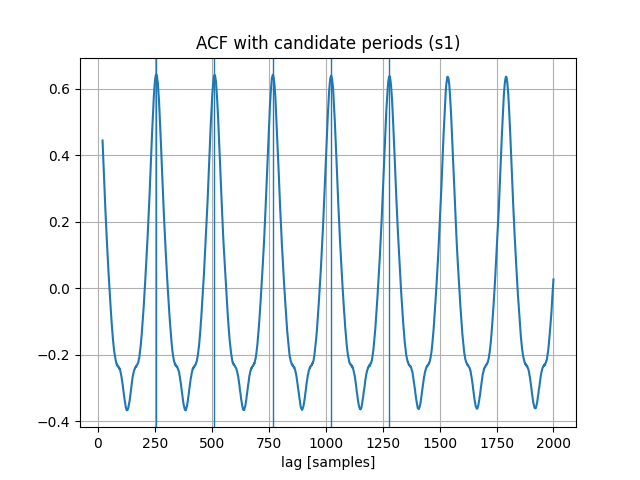

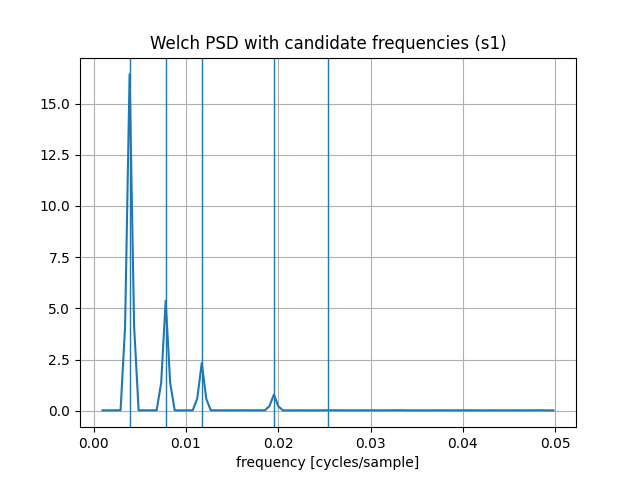

In [3]:
# ------------------------------------------------------------
# 実行（代表センサを選んで周期候補を出す）
# ------------------------------------------------------------
SENSOR_FOR_PERIOD = VALUE_COLS[0]
x = pd.to_numeric(df_tr_c[SENSOR_FOR_PERIOD], errors="coerce").to_numpy(dtype=float)

df_scores, ac, lags, f, Pxx, m, lag_min, lag_max = periodicity_scores_with_curves(
    x,
    lag_min=20,        # 探索する「最小周期」[samples]
                      # - time_col無し前提なので 1サンプル=1単位
                      # - これより短い周期（高周波）は候補から除外
                      # - 例：最短で20サンプル周期以上を見たい → lag_min=20

    lag_max=2000,      # 探索する「最大周期」[samples]
                      # - これより長い周期（低周波）は候補から除外
                      # - 例：最大で2000サンプル周期まで探す → lag_max=2000
                      # - 注意：データ長が短いと自動で n-2 に丸められる

    top_k=5,           # 各手法（ACF / PSD）で上位いくつの候補を返すか
                      # - prominence（目立ち度）が大きい順に top_k 個
                      # - 例：上位5候補だけ見たい → top_k=5

    psd_nperseg=2048,  # Welch PSD の 1区間の長さ（FFTをかける窓長）[samples]
                      # - 大きいほど周波数分解能が上がり、ピーク周波数が細かく分かる
                      # - ただし平均に使う区間数が減り、ノイズでPSDが揺れやすくなる
                      # - 小さいほど分解能は落ちるが、平均回数が増えて滑らかになりやすい
                      # - 一般に「lag_max と同程度〜数倍」か「データ長の1/4程度」から試す
                      # - SciPy welch は nperseg > len(x) のとき自動で len(x) に丸める
)

display(df_scores)

# ------------------------------------------------------------
# 可視化：ACF（候補周期に縦線）
# ------------------------------------------------------------
T_list = df_scores.loc[df_scores["method"] == "acf", "period_samples"].dropna().tolist()

plt.figure()
plt.plot(lags[lag_min:lag_max + 1], ac[lag_min:lag_max + 1])
for T in T_list:
    plt.axvline(float(T), linewidth=1)
plt.xlabel("lag [samples]")
plt.title(f"ACF with candidate periods ({SENSOR_FOR_PERIOD})")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 可視化：Welch PSD（候補周波数に縦線）
# ------------------------------------------------------------
f_list = df_scores.loc[df_scores["method"] == "psd_welch", "freq_hz"].dropna().tolist()

plt.figure()
plt.plot(f[m], Pxx[m])
for f0 in f_list:
    plt.axvline(float(f0), linewidth=1)
plt.xlabel("frequency [cycles/sample]")
plt.title(f"Welch PSD with candidate frequencies ({SENSOR_FOR_PERIOD})")
plt.grid(True)


## この図は何か（Welch PSD）

この図は「周波数ごとの強さ（エネルギー）」を並べたものです。

- 横軸：frequency [cycles/sample]
  - time_col を使わない前提なので **cycles/sample（1サンプルあたり何回繰り返すか）**
- 縦軸：PSD（その周波数成分の強さ）
  - 値が大きいほど、その周波数の繰り返し成分が強い

曲線の**山（ピーク）**が「周期性が強い周波数」です。

---

## 「周波数」から「周期（サンプル数）」への変換

横軸が cycles/sample のとき、周期（何サンプルで1回繰り返すか）は

$$
\text{period\_samples} \approx \frac{1}{f}
$$

例：
- f = 0.01 cycles/sample → period ≈ 1/0.01 = 100 samples
- f = 0.003 cycles/sample → period ≈ 333 samples

---

## 青い縦線は何か

青い縦線は、`df_scores` の `method == "psd_welch"` が選んだ
「候補周波数（上位 top_k）」の位置です。

- 曲線（PSD）：周波数ごとの強さ
- 縦線：候補（この周波数が周期っぽい）

**縦線がPSDのピーク頂上付近に刺さっていれば、その候補は妥当**です。

---

## なぜピークが複数あるのか（基本周波数と高調波）

ピークが複数出るのは普通です。

波形が「きれいな正弦波」ではなく、
尖り・段差・歪みがあると、次が同時に出ます。

- 基本周波数：いちばんゆっくりした“本体の繰り返し”
- 高調波：基本周波数の 2倍、3倍… の成分

そのため
「一番高いピーク = 本当の周期」とは限りません。

例：
- 本当の基本周波数が f0 = 0.005（周期200）
- 2倍の 0.01（周期100）が強く見えることもある

---


## データを窓ごとに整理

In [4]:
import numpy as np
import pandas as pd


# ============================================================
# 1) 連続データ(df)を「1行=1窓」に変換（窓は全センサで同じ切り方）
# ============================================================
def make_window_starts(n, win, step):
    """
    n: 全長（サンプル数）
    win: 窓長（サンプル数）
    step: ステップ（サンプル数）
    戻り: starts（各窓の開始インデックス配列）
    """
    if win <= 0 or step <= 0:
        raise ValueError("win, step は正の整数にしてください")
    if n < win:
        return np.array([], dtype=int)
    return np.arange(0, n - win + 1, step, dtype=int)


def windowize_df(
    df: pd.DataFrame,
    sensor_cols: list[str],
    win: int,
    step: int,
    time_col: str | None = None,
    label_col: str | None = None,
    label_rule: str = "center",   # "center" / "majority"
):
    """
    目的：
      - df（時刻, センサ列..., ラベル列...）から、センサごとに
        X[sensor] = shape(n_win, win) の「1行=1窓」行列を作る
      - 併せて、各窓の開始/終了/中心インデックス、(あれば)中心時刻、(あれば)窓ラベル を meta にまとめる

    戻り：
      X_dict: {sensor_name: np.ndarray(n_win, win)}
      meta  : pd.DataFrame（各窓の情報）
    """
    # --- 列チェック（必要なら外してOK）
    for c in sensor_cols:
        if c not in df.columns:
            raise ValueError(f"sensor_cols に指定した列がありません: {c}")
    if time_col is not None and time_col not in df.columns:
        raise ValueError(f"time_col が df にありません: {time_col}")
    if label_col is not None and label_col not in df.columns:
        raise ValueError(f"label_col が df にありません: {label_col}")

    n = len(df)
    starts = make_window_starts(n, win, step)
    n_win = starts.size

    # --- meta（窓の位置情報）
    meta = pd.DataFrame({
        "win_i": np.arange(n_win, dtype=int),
        "start_idx": starts,
        "end_idx": starts + win - 1,
        "center_idx": starts + (win // 2),
    })

    # --- 時刻（あれば）
    if time_col is not None:
        t = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
        meta["center_time"] = t[meta["center_idx"].to_numpy(dtype=int)]

    # --- ラベル（あれば）
    if label_col is not None:
        lab = df[label_col].to_numpy()
        if label_rule == "center":
            meta["win_label"] = lab[meta["center_idx"].to_numpy(dtype=int)]
        elif label_rule == "majority":
            # 多数決（カテゴリでもOK）
            wl = []
            for s in starts:
                seg = lab[s:s + win]
                # NaN除外
                seg = seg[~pd.isna(seg)]
                if seg.size == 0:
                    wl.append(np.nan)
                else:
                    v, cnt = np.unique(seg, return_counts=True)
                    wl.append(v[int(np.argmax(cnt))])
            meta["win_label"] = wl
        else:
            raise ValueError("label_rule は 'center' か 'majority' を指定してください")

    # --- センサごとの X を作る（全センサ同じ starts を使う）
    X_dict = {}
    for c in sensor_cols:
        x = pd.to_numeric(df[c], errors="coerce").to_numpy(dtype=float)
        # 1行=1窓（n_win, win）
        X = np.stack([x[s:s + win] for s in starts], axis=0) if n_win else np.empty((0, win), dtype=float)
        X_dict[c] = X

    return X_dict, meta



In [5]:

# ============================================================
# 2) 使い方（train/test どちらにも同じ関数を使う）
# ============================================================
df_tr = read_csv_robust(TRAIN_CSV)
df_te = read_csv_robust(TEST_CSV)

# センサ列
SENSOR_COLS = ["s1"]

# 窓設定（任意）
WIN  = 256
STEP = 256  # 256なら非重複、128なら50%重複
X_tr_dict, meta_tr = windowize_df(df_tr, SENSOR_COLS, WIN, STEP, time_col=TIME_COL, label_col=LABEL_COL, label_rule="center")
X_te_dict, meta_te = windowize_df(df_te, SENSOR_COLS, WIN, STEP, time_col=TIME_COL, label_col=LABEL_COL, label_rule="center")

# 例：s1 の「1行=1窓」行列
X_tr_s1 = X_tr_dict["s1"]   # shape (n_win, WIN)
X_te_s1 = X_te_dict["s1"]

X_te_s1
meta_te

,win_i,start_idx,end_idx,center_idx,center_time,win_label
0,0,0,255,128,1.28,0
1,1,256,511,384,3.84,0
2,2,512,767,640,6.40,0
3,3,768,1023,896,8.96,0
4,4,1024,1279,1152,11.52,0
...,...,...,...,...,...,...
1395,1395,357120,357375,357248,3572.48,0
1396,1396,357376,357631,357504,3575.04,0
1397,1397,357632,357887,357760,3577.60,0
1398,1398,357888,358143,358016,3580.16,0


## 特徴量の算出

In [6]:
import numpy as np
import pandas as pd
from scipy import signal, stats


# ============================================================
# 前提：
#   windowize_df() の出力をそのまま受け取る
#     X_dict: {sensor: ndarray (n_win, win)}
#     meta  : DataFrame（win_i/start_idx/end_idx/center_idx/(win_label) など）
#
# 目的：
#   1行=1窓の特徴量 DataFrame を作る（meta列 + sensor別特徴量列）
# ============================================================


# ============================================================
# 共通：窓内の欠損を埋める（NaN/infを残さない）
# ============================================================
def _fill_nan_1d(x):
    """
    x を 1次元 float 配列にして、NaN/inf があれば「窓内中央値」で埋める
    """
    x = np.asarray(x, dtype=float).ravel()                 # 1次元化して float に統一
    if np.any(~np.isfinite(x)):                            # NaN/inf があるか
        med = np.nanmedian(x)                              # NaN を無視した中央値
        x = np.where(np.isfinite(x), x, med)               # finite 以外を中央値で置換
    return x


# ============================================================
# (2)(3) テンプレ作成：学習窓からセンサごとの平均テンプレ
#   - 形状比較をしたいので「窓ごとの平均を引いて」から平均する
#   - オフセット(上下シフト)は(4)で別特徴として持つため、ここで消す
# ============================================================
def build_templates_from_train_windows(X_tr_dict):
    """
    X_tr_dict: {sensor: array(n_win, win)}
    戻り     : tmpl_dict {sensor: array(win,)}
    """
    tmpl_dict = {}
    for sensor, X in X_tr_dict.items():
        X = np.asarray(X, dtype=float)

        if X.size == 0:
            tmpl_dict[sensor] = np.full((0,), np.nan)
            continue

        A = np.empty_like(X, dtype=float)                 # 学習窓を「形状化」した配列
        for i in range(X.shape[0]):
            w = _fill_nan_1d(X[i])                         # 欠損を埋める
            w = w - np.mean(w)                             # 窓内平均を引く（オフセット除去）
            A[i] = w                                       # 形状化した窓を保存

        tmpl_dict[sensor] = A.mean(axis=0)                 # 学習窓平均 = テンプレ

    return tmpl_dict


# ============================================================
# (1) 周波数成分：Welch PSD → ピーク周波数・帯域パワー
# ============================================================
def feat_psd_one(w, fs=1.0, nperseg=256, bands=None):
    """
    w      : 1窓（1D）
    fs     : time_col無しなら 1.0 でOK（周波数は cycles/sample）
    nperseg: Welch の区間長（FFT窓長）
    bands  : [(f1,f2), ...] の帯域（fsに依存）
    """
    x = _fill_nan_1d(w)                                   # 欠損を埋める
    x0 = x - np.mean(x)                                   # 平均を引く（0Hz支配を抑える）

    f, Pxx = signal.welch(
        x0,
        fs=fs,
        window="hann",
        nperseg=min(int(nperseg), len(x)),                # データ長より長くならないようにする                                # 平均を引く（0Hz支配を抑える）
        scaling="density",
    )

    # ピーク周波数（f>0 の範囲で最大パワー）
    m = (f > 0) & np.isfinite(Pxx)  # 0Hz（平均成分）を除外し、Pxxが有限値の点だけを対象にするマスク
    if not np.any(m):               # 有効な点が1つも無い（全部NaN/inf、またはf>0が無い）なら安全に0で返す
        out = {"psd_peak_freq": 0.0, "psd_peak_power": 0.0}
    else:
        f2, p2 = f[m], Pxx[m]       # 有効な周波数だけを抜き出した配列（f2とp2は同じ長さ）
        k = int(np.argmax(p2))      # p2が最大になる「位置（インデックス）」を取る（kは0〜len(p2)-1の整数）
        out = {
            "psd_peak_freq": float(f2[k]),   # 最大パワーを出している周波数（=ピーク周波数）
            "psd_peak_power": float(p2[k])   # その周波数でのパワー（=ピークの高さ）
        }

    # 帯域パワー（PSDを周波数で積分）
    if bands is None:
        fnyq = 0.5 * fs
        # bands を指定しない場合は、[0, fs/2] を 3分割した帯域を自動で作る
        # 例）fs=1.0なら fnyq=0.5 なので
        #   (0.0, 0.1666...), (0.1666..., 0.3333...), (0.3333..., 0.5)
        bands = [
            (0.0,       fnyq / 3),
            (fnyq / 3,  2 * fnyq / 3),
            (2 * fnyq / 3, fnyq)
        ]

    # bands に入っている各帯域 [a, b) について、帯域パワーを計算する
    for (a, b) in bands:
        # この帯域に入る周波数だけを選ぶマスク
        # かつ、Pxxが有限値（NaN/infでない）だけを使う
        mm = (f >= a) & (f < b) & np.isfinite(Pxx)

        # np.trapz(y, x) は「x軸に沿って y を台形公式で積分」する関数
        # ここでは y=Pxx, x=f なので、「周波数 a〜b の範囲でPSDを面積として合計」している
        # → それが「帯域パワー（band power）」になる
        out[f"bandpower_{a:g}_{b:g}"] = float(np.trapz(Pxx[mm], f[mm])) if np.any(mm) else 0.0

    return out


# ============================================================
# (3) 位相ズレ：相互相関でラグ推定（±max_lag）
# ============================================================
def best_lag_xcorr(x, t, max_lag=10):
    """
    x: 窓波形（1D）
    t: テンプレ（1D）
    戻り：lag（int）, score（正規化相互相関）
    """
    x = np.asarray(x, dtype=float).ravel()
    t = np.asarray(t, dtype=float).ravel()

    # 相互相関がオフセット(平均)に引っ張られないよう、平均を引く
    x0 = x - np.mean(x)
    t0 = t - np.mean(t)

    # full 相互相関（FFTで高速化）
    c = signal.correlate(x0, t0, mode="full", method="fft")
    lags = signal.correlation_lags(len(x0), len(t0), mode="full")

    # 探索範囲を ±max_lag に限定（実務では探索幅を狭めるのが定石）
    m = (lags >= -max_lag) & (lags <= max_lag)
    idx = int(np.argmax(c[m]))                            # 相互相関最大の位置
    lag = int(lags[m][idx])                               # そのラグ（サンプル単位）

    # 正規化相互相関（値域の目安を揃える）
    denom = (np.linalg.norm(x0) * np.linalg.norm(t0) + 1e-12)
    score = float(c[m][idx] / denom)

    return lag, score


def _align_by_lag(x, t, lag):
    """
    推定ラグに合わせて「重なる部分」だけ切り出す（循環シフトはしない）
    """
    if lag > 0:
        return x[lag:], t[:-lag]
    if lag < 0:
        return x[:lag], t[-lag:]
    return x, t


# ============================================================
# (2) 波形の変化（形）：テンプレ比較（相関・誤差）
# (3) 位相ズレ：phase_lag と xcorr_score
# ============================================================
def feat_template_one(w, tmpl, max_lag=10):
    x = _fill_nan_1d(w)
    t = _fill_nan_1d(tmpl)

    # 形状比較のため、オフセットは外す（オフセットは(4)で別特徴）
    x0 = x - np.mean(x)
    t0 = t - np.mean(t)

    lag, xcorr_score = best_lag_xcorr(x0, t0, max_lag=max_lag)
    xa, ta = _align_by_lag(x0, t0, lag)

    # データが短すぎると相関や誤差が不安定なので、0で返す（NaN回避）
    if xa.size < 3 or ta.size < 3:
        return {
            "phase_lag": int(lag),
            "xcorr_score": float(xcorr_score),
            "corrcoef_aligned": 0.0,
            "mse": 0.0, "rmse": 0.0, "nrmse": 0.0, "mae": 0.0
        }

    # 相関係数（形がどれだけ似ているか）
    if np.std(xa) < 1e-12 or np.std(ta) < 1e-12:
        corrcoef = 0.0
    else:
        corrcoef = float(np.corrcoef(xa, ta)[0, 1])

    # 誤差（どれだけ違うか）
    diff = xa - ta
    mse = float(np.mean(diff**2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(diff)))

    # NRMSE（テンプレのレンジで正規化）
    denom = float(np.ptp(ta))
    nrmse = float(rmse / (denom + 1e-12)) if denom > 0 else 0.0

    return {
        "phase_lag": int(lag),
        "xcorr_score": float(xcorr_score),
        "corrcoef_aligned": corrcoef,
        "mse": mse, "rmse": rmse, "nrmse": nrmse, "mae": mae
    }


# ============================================================
# (4) 上下シフト（オフセット）：平均・中央値
# ============================================================
def feat_offset_one(w):
    x = _fill_nan_1d(w)
    return {"mean": float(np.mean(x)), "median": float(np.median(x))}


# ============================================================
# (5) スパイク：A（しきい値超え hit の特徴量）
#   - NaN を返さない（hit無しは 0）
#   - 「イベントとしてのスパイク」を扱いやすい形にする
# ============================================================
def feat_spike_one_A(w, thr):
    """
    w  : 1窓（1D）
    thr: しきい値（|w0| が thr を超えたら hit）
         ※w0 = w - mean(w)（オフセット除去後）で判定する
    """
    x = _fill_nan_1d(w)                                   # 欠損を埋める
    x0 = x - np.mean(x)                                   # オフセット除去（上下シフトの影響を減らす）
    a = np.abs(x0)                                        # 振幅（両極性をまとめる）

    # 連続量（hit有無に関係なく必ず計算できる値）
    peak_amp = float(np.max(a)) if a.size else 0.0
    strength_l1 = float(np.sum(a))
    energy_l2 = float(np.sum(x0 * x0))

    # しきい値が不正な場合は「hit無し」になるように安全側へ倒す
    thr = float(thr) if np.isfinite(thr) else np.inf
    if thr < 0:
        thr = 0.0

    hit = (a >= thr)

    # hit が無い窓：0で返す（NaNにしない）
    if not np.any(hit):
        return {
            "has_hit": 0,
            "peak_amplitude": peak_amp,
            "hit_samples": 0,
            "counts": 0,
            "duration_samples": 0,
            "rise_time_samples": 0,
            "signal_strength_l1": strength_l1,
            "energy_l2": energy_l2,
        }

    idx = np.where(hit)[0]
    i0 = int(idx[0])                                      # 最初の hit
    i1 = int(idx[-1])                                     # 最後の hit

    # counts：hit 区間の開始回数（False→True の回数）
    hseg = hit[i0:i1 + 1]
    counts = int(np.sum((~hseg[:-1]) & (hseg[1:])) + (1 if hseg[0] else 0))

    # rise_time：最初の hit から peak まで
    ip = int(np.argmax(a[i0:i1 + 1]) + i0)

    return {
        "has_hit": 1,
        "peak_amplitude": peak_amp,
        "hit_samples": int(np.sum(hit)),
        "counts": counts,
        "duration_samples": int(i1 - i0),
        "rise_time_samples": int(ip - i0),
        "signal_strength_l1": strength_l1,
        "energy_l2": energy_l2,
    }


# ============================================================
# しきい値が手元に無い場合：学習（正常）窓から推定して作る
#   - センサごとに「ノイズより少し上」になるような値を作る用途
#   - ここでは abs(w-mean(w)) の分布から median + k*MAD を採用
# ============================================================
def estimate_spike_thr_from_train_Xdict(X_tr_dict, k=6.0):
    """
    X_tr_dict: {sensor: array(n_win, win)}（学習=正常窓）
    k       : 大きいほど厳しめ（誤検知↓、見逃し↑）
    戻り    : thr_dict {sensor: thr}
    """
    thr_dict = {}
    for sensor, X in X_tr_dict.items():
        X = np.asarray(X, dtype=float)
        if X.size == 0:
            thr_dict[sensor] = np.nan
            continue

        vals = []
        for i in range(X.shape[0]):
            w = _fill_nan_1d(X[i])
            w0 = w - np.mean(w)
            vals.append(np.abs(w0))
        v = np.concatenate(vals)

        med = float(np.median(v))
        mad = float(np.median(np.abs(v - med)))
        thr_dict[sensor] = med + float(k) * 1.4826 * mad

    return thr_dict


# ============================================================
# まとめ：X_dict/meta → 1行=1窓 の特徴量 DataFrame
# ============================================================
def compute_features_from_windowized(
    X_dict,
    meta,
    tmpl_dict=None,
    fs=1.0,
    psd_nperseg=256,
    psd_bands=None,
    max_lag=10,
    spike_thr_by_sensor=None,   # dict {sensor: thr} または float（共通thr）
):
    """
    spike_thr_by_sensor は必須（A方式のhit特徴量はしきい値が必要）
    """
    if spike_thr_by_sensor is None:
        raise ValueError("spike_thr_by_sensor（しきい値）が必要です。手動指定か estimate_spike_thr_from_train_Xdict を使ってください。")

    sensors = list(X_dict.keys())
    n_win = int(meta.shape[0])

    rows = []
    for i in range(n_win):
        row = {}

        # meta列を先頭に入れる（1行=1窓）
        for c in meta.columns:
            row[c] = meta.iloc[i][c]

        for sensor in sensors:
            w = X_dict[sensor][i]

            # (1) 周波数
            d1 = feat_psd_one(w, fs=fs, nperseg=psd_nperseg, bands=psd_bands)

            # (2)(3) テンプレ比較（テンプレがあるときだけ）
            d23 = {}
            if tmpl_dict is not None and sensor in tmpl_dict:
                d23 = feat_template_one(w, tmpl_dict[sensor], max_lag=max_lag)

            # (4) オフセット
            d4 = feat_offset_one(w)

            # (5) スパイク（A方式：hit）
            thr = spike_thr_by_sensor[sensor] if isinstance(spike_thr_by_sensor, dict) else float(spike_thr_by_sensor)
            d5 = feat_spike_one_A(w, thr=thr)

            # まとめて結合（列名衝突を避けるため sensor__feature にする）
            for k, v in {**d1, **d23, **d4, **d5}.items():
                row[f"{sensor}__{k}"] = v

        rows.append(row)

    return pd.DataFrame(rows)



In [7]:

# ============================================================
# 使い方（windowize_df の直後に繋げる例）
#   ※windowize_df は「既にある」前提
# ============================================================
# 1) テンプレ作成（形状比較を使う場合）
tmpl_dict = build_templates_from_train_windows(X_tr_dict)

# 2) スパイクしきい値（A方式）
#    2-a) 現場で決まっているなら手動指定（推奨）
spike_thr = {"s1": 1.5, "s2": 1.5, "s3": 1.5}
#    2-b) 無いなら学習（正常）から推定（とりあえず動かす用）
# spike_thr = estimate_spike_thr_from_train_Xdict(X_tr_dict, k=6.0)

# 3) 特徴量化（1行=1窓）
df_feat_tr = compute_features_from_windowized(
    X_tr_dict,
    meta_tr,
    tmpl_dict=tmpl_dict,
    fs=1.0,
    psd_nperseg=2048,
    psd_bands=[(0.0, 0.01), (0.01, 0.03), (0.03, 0.5)],
    max_lag=10,
    spike_thr_by_sensor=spike_thr,
)

df_feat_te = compute_features_from_windowized(
    X_te_dict,
    meta_te,
    tmpl_dict=tmpl_dict,
    fs=1.0,
    psd_nperseg=2048,
    psd_bands=[(0.0, 0.01), (0.01, 0.03), (0.03, 0.5)],
    max_lag=10,
    spike_thr_by_sensor=spike_thr,
)

df_feat_te


,win_i,start_idx,end_idx,center_idx,center_time,win_label,s1__psd_peak_freq,s1__psd_peak_power,s1__bandpower_0_0.01,s1__bandpower_0.01_0.03,...,s1__mean,s1__median,s1__has_hit,s1__peak_amplitude,s1__hit_samples,s1__counts,s1__duration_samples,s1__rise_time_samples,s1__signal_strength_l1,s1__energy_l2
0,0.0,0.0,255.0,128.0,1.28,0.0,0.003906,1.630646,0.011040,0.002866,...,0.003834,0.008501,0,0.423883,0,0,0,0,35.081725,7.424209
1,1.0,256.0,511.0,384.0,3.84,0.0,0.003906,2.201199,0.014302,0.003325,...,-0.012442,-0.014887,0,0.513496,0,0,0,0,36.446225,7.612957
2,2.0,512.0,767.0,640.0,6.40,0.0,0.003906,1.839497,0.012188,0.002695,...,0.004215,0.009289,0,0.411635,0,0,0,0,33.579508,6.843442
3,3.0,768.0,1023.0,896.0,8.96,0.0,0.003906,2.245845,0.013808,0.003326,...,-0.001243,-0.003583,0,0.492532,0,0,0,0,36.247382,7.737960
4,4.0,1024.0,1279.0,1152.0,11.52,0.0,0.003906,1.849883,0.011765,0.004113,...,-0.000831,0.010865,0,0.461127,0,0,0,0,34.208851,6.916315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1395.0,357120.0,357375.0,357248.0,3572.48,0.0,0.003906,1.657348,0.010571,0.002185,...,0.021508,0.015149,0,0.494202,0,0,0,0,34.412614,6.726516
1396,1396.0,357376.0,357631.0,357504.0,3575.04,0.0,0.003906,2.372374,0.014521,0.003181,...,0.005547,0.007586,0,0.493055,0,0,0,0,36.297287,8.050916
1397,1397.0,357632.0,357887.0,357760.0,3577.60,0.0,0.003906,2.010828,0.012591,0.002936,...,-0.007156,-0.011902,0,0.497498,0,0,0,0,36.363277,7.709257
1398,1398.0,357888.0,358143.0,358016.0,3580.16,0.0,0.003906,2.253791,0.014374,0.003101,...,0.011282,0.016686,0,0.462177,0,0,0,0,34.627763,7.313048


In [8]:
# df_feat_tr / df_feat_te をCSV保存（Excelで開けるutf-8-sig）
df_feat_tr.to_csv("features_train_s1.csv", index=False, encoding="utf-8-sig")
df_feat_te.to_csv("features_test_s1.csv",  index=False, encoding="utf-8-sig")

print("saved: features_train.csv, features_test.csv")
print("train:", df_feat_tr.shape, "test:", df_feat_te.shape)


saved: features_train.csv, features_test.csv
train: (500, 28) test: (1400, 28)


In [9]:
# ============================================================
# ここから下だけ追加（既存の plot_tiled_timeseries を流用）
# 前提：df_feat_tr, df_feat_te が既にできている
# ============================================================

def pick_time_col_for_features(df_feat: pd.DataFrame) -> str | None:
    # windowize_df 由来の時刻があればそれを使う。無ければ中心index。
    if "center_time" in df_feat.columns:
        return "center_time"
    if "center_idx" in df_feat.columns:
        return "center_idx"
    if "win_i" in df_feat.columns:
        return "win_i"
    return None  # plot_tiled_timeseries 内で index 扱いになる

def plot_features_tiled(
    df_feat_tr: pd.DataFrame,
    df_feat_te: pd.DataFrame,
    feat_cols: list[str],
    center_by_train: bool = False,      # True: 学習平均との差し引き（表示を揃える用途）
    title_tr: str = "TRAIN features",
    title_te: str = "TEST features",
):
    # x軸とラベル列（特徴量側は win_label が基本）
    time_col = pick_time_col_for_features(df_feat_tr)
    label_col = "win_label" if "win_label" in df_feat_tr.columns else None

    # 欠損や文字列混入があると plot で落ちるので、ここで数値化（列ごと）
    tr = df_feat_tr.copy()
    te = df_feat_te.copy()
    for c in feat_cols:
        tr[c] = pd.to_numeric(tr[c], errors="coerce")
        te[c] = pd.to_numeric(te[c], errors="coerce")

    # 任意：学習平均との差し引き（“形”を見るときだけ使うのが無難）
    if center_by_train:
        tr, te = center_by_train_mean(tr, te, feat_cols)

    # 学習・テストで同じ y軸範囲
    ylims = compute_ylims(tr, te, feat_cols)

    plot_tiled_timeseries(
        tr,
        time_col=time_col,
        value_cols=feat_cols,
        label_col=label_col,
        title=title_tr + (" (centered)" if center_by_train else ""),
        ylims_by_col=ylims,
    )

    plot_tiled_timeseries(
        te,
        time_col=time_col,
        value_cols=feat_cols,
        label_col=label_col,
        title=title_te + (" (centered)" if center_by_train else ""),
        ylims_by_col=ylims,
    )


# ============================================================
# 使い方例：まずは“位相（ラグ）”まわりだけ見る
# ============================================================
FEAT_COLS = [
    "s1__phase_lag",
    "s2__phase_lag",
    "s3__phase_lag",
    "s1__xcorr_score",
    "s2__xcorr_score",
    "s3__xcorr_score",
]

plot_features_tiled(
    df_feat_tr, df_feat_te,
    feat_cols=FEAT_COLS,
    center_by_train=False,   # phase_lag は中心化しない方が見やすい
    title_tr="TRAIN features (phase)",
    title_te="TEST features (phase)",
)


# ============================================================
# 例：スパイク系だけ見る（has_hit は0/1なので中心化しないのが無難）
# ============================================================
FEAT_COLS2 = [
    "s1__has_hit", "s1__peak_amplitude", "s1__hit_samples",
    "s2__has_hit", "s2__peak_amplitude", "s2__hit_samples",
    "s3__has_hit", "s3__peak_amplitude", "s3__hit_samples",
]

plot_features_tiled(
    df_feat_tr, df_feat_te,
    feat_cols=FEAT_COLS2,
    center_by_train=False,
    title_tr="TRAIN features (spike)",
    title_te="TEST features (spike)",
)


# ============================================================
# 例：周波数系だけ見る（中心化はどちらでもOK）
# ============================================================
FEAT_COLS3 = [
    "s1__psd_peak_freq", "s1__psd_peak_power",
    "s2__psd_peak_freq", "s2__psd_peak_power",
    "s3__psd_peak_freq", "s3__psd_peak_power",
]
plot_features_tiled(
    df_feat_tr, df_feat_te,
    feat_cols=FEAT_COLS3,
    center_by_train=False,
    title_tr="TRAIN features (PSD)",
    title_te="TEST features (PSD)",
)


KeyError: 's2__phase_lag'